In [3]:
%matplotlib inline
'''
This script is used for inspecting the anomalies presented in the classification.
'''

'\nThis script is used for inspecting the anomalies presented in the classification.\n'

In [105]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from csv import reader
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.stem.snowball import SnowballStemmer
from util import plot_confusion_matrix
from collections import Counter

In [7]:
with open('topic.csv', 'r') as f:
    topic_data = list(reader(f))[1:]

    # ground truth labels
    true_labels = [x[0] for x in topic_data]

    # pre-processing raw data
    # merging title and body
    topic_data = [x[2] + ' ' + x[3] for x in topic_data]
    # convert string labels to integer
    le = LabelEncoder()
    y = le.fit_transform(true_labels)
    label_names = le.classes_

    # split training and test data
#     X_train, X_test, y_train, y_test = train_test_split(topic_data, y, test_size=0.2)
#     n_train = len(X_train)

    # create pipeline
    doc_classification = Pipeline(
        [('vect', CountVectorizer(binary=True)),
         ('clf', LogisticRegressionCV())]
    )

    # training the model
    # 3-fold
    y_hat = cross_val_predict(doc_classification, topic_data, y)
    acc = accuracy_score(y, y_hat)

In [55]:
experiment1 = Pipeline(
    [
        ('vect', CountVectorizer(binary=False)),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegressionCV())
    ]
)

def experiment1_tf_idf(X, y):
    clf = experiment1.fit(X, y)
    y_hat = cross_val_predict(clf, X, y)
    return y_hat

y_hat_1 = experiment1_tf_idf(topic_data, y)
acc_1 = accuracy_score(y, y_hat_1)

In [64]:
expriment2 = Pipeline(
    [
        ('vect', CountVectorizer(binary=False, ngram_range=(1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegressionCV())
    ]
)

def experiment2_2_gram(X, y):
    clf = expriment2.fit(X, y)
    y_hat = cross_val_predict(clf, X, y)
    return y_hat

y_hat_2 = experiment2_2_gram(topic_data, y)
acc_2 = accuracy_score(y, y_hat_2)

In [97]:
# remove stop words
experiment3_stop_words = Pipeline(
    [
        ('vect', CountVectorizer(stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegressionCV())
    ]
)

def experiment(pipeline, X, y):
    clf = pipeline.fit(X, y)
    y_hat = cross_val_predict(clf, X, y)
    return y_hat
    
y_hat_3 = experiment(experiment3_stop_words, topic_data, y)
acc_3 = accuracy_score(y, y_hat_3)

In [102]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

experiment4_stem = Pipeline(
    [
        ('vect', StemmedCountVectorizer(stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegressionCV())
    ]
)

stemmer = SnowballStemmer('english', ignore_stopwords=True)
y_hat_4 = experiment(experiment4_stem, topic_data, y)
acc_4 = accuracy_score(y, y_hat_4)

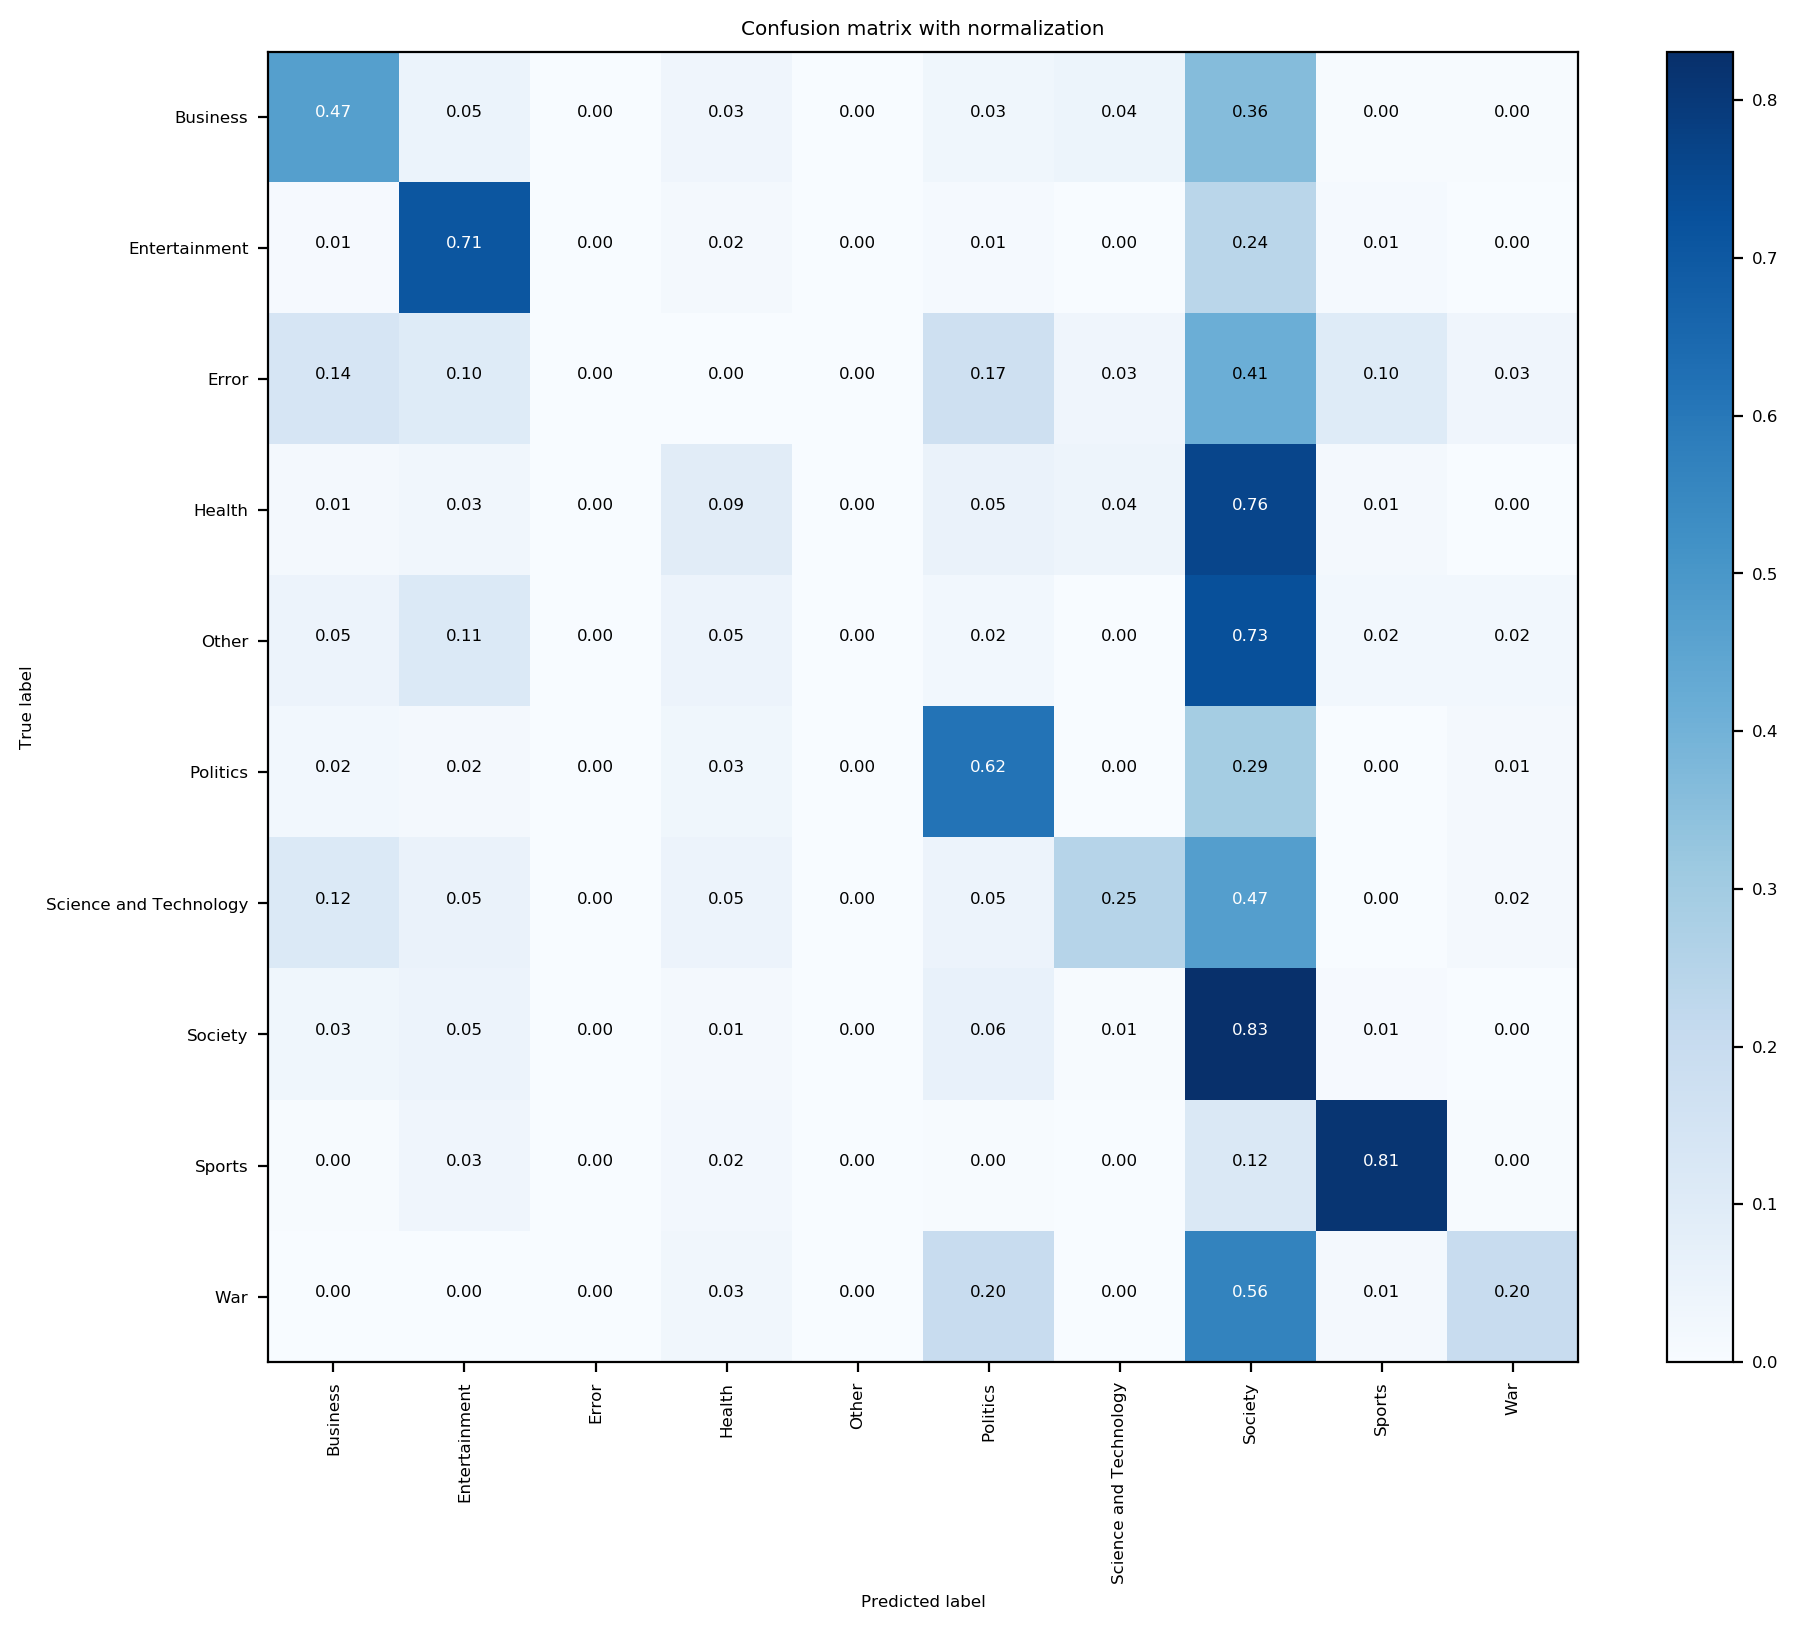

In [53]:
cm = confusion_matrix(y, y_hat)
np.set_printoptions(precision=2)
plt.figure(figsize=(10, 8), dpi=200)
plot_confusion_matrix(cm, classes=label_names, normalize=True, title='Confusion matrix with normalization')

In [110]:
misclassified = np.where(y != y_hat)
misclassified[0].tolist()

print(acc)
print(acc_1)
print(acc_2)
print(acc_3)
print(acc_4)

0.6392294220665499
0.6624343257443083
0.6449211908931699
0.6637478108581436
0.670753064798599


In [57]:
def precision(cm, i):
    col = cm[:, i]
    positive = sum(col)
    tp = col[i]
    if positive != 0:
        return tp / positive
    else:
        return float('nan')


def recall(cm , i):
    row = cm[i]
    positive = sum(row)
    tp = row[i]
    if positive != 0:
        return tp / positive
    else:
        return float('nan')

In [95]:
# precision and recall
# labels = label_names.tolist()
# for n in labels:
#     p.append([n, precision(cm, labels.index(n))])
# p = sorted(p, key=lambda x: x[1], reverse=True)

# print('precisions:')
# for i in p:
#     print(i)

r = []
for n in labels:
    r.append([n, recall(cm, labels.index(n))])
r = sorted(r, key=lambda x: x[1], reverse=True)
    
print('recalls:')

for i in r: 
    print(i)

recalls:
['Society', 0.8309248554913294]
['Sports', 0.8125]
['Entertainment', 0.7094430992736077]
['Politics', 0.616519174041298]
['Business', 0.47058823529411764]
['Science and Technology', 0.24806201550387597]
['War', 0.19718309859154928]
['Health', 0.09333333333333334]
['Error', 0.0]
['Other', 0.0]


In [107]:
Counter(true_labels)

Counter({'Business': 204,
         'Entertainment': 413,
         'Error': 29,
         'Health': 75,
         'Other': 44,
         'Politics': 339,
         'Science and Technology': 129,
         'Society': 692,
         'Sports': 288,
         'War': 71})